[View in Colaboratory](https://colab.research.google.com/github/adrshm91/DrivFace/blob/master/DrivFace_Augumentation.ipynb)

In [0]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
temp_dir = 'data/temp'
orig_dir = 'data/images'
train_dir = 'data/train'
val_dir = 'data/val'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'

In [0]:
def load_dataset():
  if not os.path.exists(orig_dir):
    
    # download the dataset
    
    os.makedirs(temp_dir)
    os.makedirs(orig_dir)
    print("Downloading dataset to "+ temp_dir)
    file = wget.download(url, out=temp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(temp_dir)
    pzf = PyZipFile(temp_dir+'/DrivFace/DrivImages.zip')
    pzf.extractall(temp_dir)
    print("Moving files to "+orig_dir)
    for file in os.listdir(temp_dir+'/DrivImages'):
      shutil.move(temp_dir+'/DrivImages/'+file,orig_dir+'/'+file)
    shutil.move(temp_dir+'/DrivFace/drivPoints.txt',orig_dir+'/drivPoints.txt')
    print("Deleting temporary directory "+ temp_dir)
    shutil.rmtree(temp_dir)

In [0]:
def split_dataset(orig_dir, train_dir, val_dir, split_ratio):
  
  if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    print("Creating train directories for each class")
    train_ff_dir = os.path.join(train_dir, 'ff')
    os.makedirs(train_ff_dir)
    train_ll_dir = os.path.join(train_dir, 'll')
    os.makedirs(train_ll_dir)
    train_lr_dir = os.path.join(train_dir, 'lr')
    os.makedirs(train_lr_dir)

    print("Creating val directories for each class")
    val_ff_dir = os.path.join(val_dir, 'ff')
    os.makedirs(val_ff_dir)
    val_ll_dir = os.path.join(val_dir, 'll')
    os.makedirs(val_ll_dir)
    val_lr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(val_lr_dir)

    files = pd.read_csv(orig_dir+'/drivPoints.txt')['fileName'].tolist()
    files_ff = [file for file in files if 'f' in file]
    files_ll = [file for file in files if 'll' in file]
    files_lr = [file for file in files if 'lr' in file]
    i = 0
    for fname in files_ff:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_ff_dir, fname + '.jpg')
      dst_val = os.path.join(val_ff_dir, fname + '.jpg')
      i += 1
      if i < len(files_ff)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)
    i = 0
    for fname in files_ll:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_ll_dir, fname + '.jpg')
      dst_val = os.path.join(val_ll_dir, fname + '.jpg')
      i += 1
      if i < len(files_ll)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)
    i = 0
    for fname in files_lr:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_lr_dir, fname + '.jpg') 
      dst_val = os.path.join(val_lr_dir, fname + '.jpg')
      i += 1
      if i < len(files_lr)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)

In [0]:
load_dataset()

In [0]:
split_dataset(orig_dir, train_dir, val_dir, split_ratio = 0.8)

In [7]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
__________

In [0]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

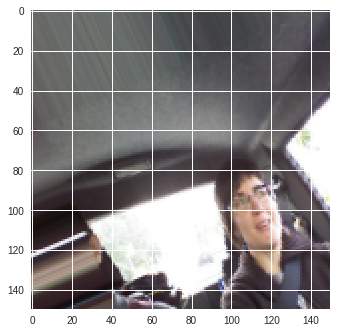

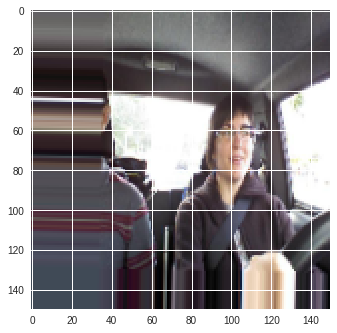

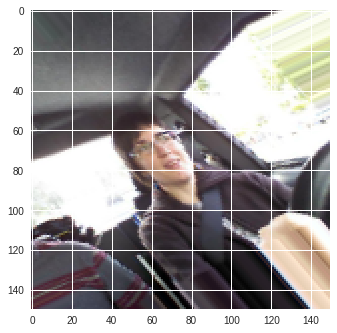

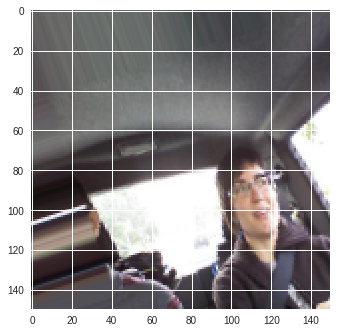

In [13]:
from keras.preprocessing import image   
import matplotlib.pyplot as plt

train_dir_f = train_dir + '/ff'
fnames = [os.path.join(train_dir_f, fname) for
     fname in os.listdir(train_dir_f)]
img_path = fnames[3]                                            

img = image.load_img(img_path, target_size=(150, 150))          

x = image.img_to_array(img)                                 
x = x.reshape((1,) + x.shape)                                   

i = 0                                                           
for batch in datagen.flow(x, batch_size=1):                     
    plt.figure(i)                                               
    imgplot = plt.imshow(image.array_to_img(batch[0]))          
    i += 1                                                      
    if i % 4 == 0:                                              
        break                                                   

plt.show()

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,)

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir,                                              
        target_size=(150, 150),                                 
        batch_size=32,
        class_mode='categorical')

Found 483 images belonging to 3 classes.


In [18]:
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 123 images belonging to 3 classes.


In [19]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 47s 469ms/step - loss: 0.4218 - acc: 0.9001 - val_loss: 0.4327 - val_acc: 0.8935
Epoch 2/30
100/100 [==============================] - 41s 411ms/step - loss: 0.4223 - acc: 0.8967 - val_loss: 0.4401 - val_acc: 0.8948
Epoch 3/30
100/100 [==============================] - 42s 416ms/step - loss: 0.3859 - acc: 0.9035 - val_loss: 0.4459 - val_acc: 0.8942
Epoch 4/30
100/100 [==============================] - 44s 437ms/step - loss: 0.3956 - acc: 0.8970 - val_loss: 0.5080 - val_acc: 0.8935
Epoch 5/30
100/100 [==============================] - 42s 416ms/step - loss: 0.3855 - acc: 0.9000 - val_loss: 0.4587 - val_acc: 0.8942
Epoch 6/30
100/100 [==============================] - 41s 410ms/step - loss: 0.3709 - acc: 0.9008 - val_loss: 0.4858 - val_acc: 0.8942
Epoch 7/30
100/100 [==============================] - 42s 416ms/step - loss: 0.3539 - acc: 0.9018 - val_loss: 0.4764 - val_acc: 0.8955
Epoch 8/30
100/100 [==============================] - 4

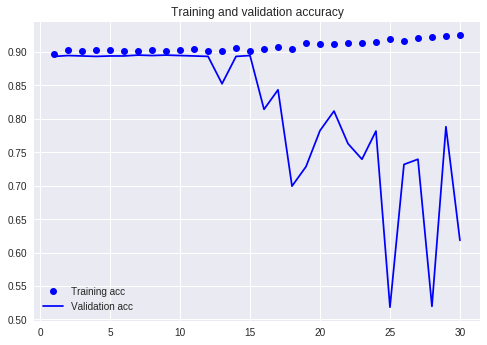

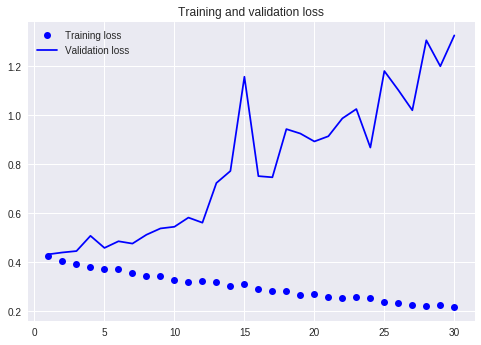

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()